# LLM Settings

In [1]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

api_key=os.environ.get("openrouter_api_key")

In [2]:
# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(
#     model = "qwen/qwen3-14b:free", # "qwen/qwen3-14b:free", "qwen/qwen3-30b-a3b:free",
#     base_url="https://openrouter.ai/api/v1",
#     api_key=api_key,
#     )

from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0, max_tokens=8000,) # "gemma2-9b-it", qwen-qwq-32b "llama-3.3-70b-versatile"  llama-3.1-8b-instant

# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(
#     model = "qwen3:4b",
#     base_url="http://localhost:11434/v1",
#     api_key="ollama",
# )

llm.invoke("안녕")

AIMessage(content='안녕하세요. 저는 어떻게 도와드릴까요?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 37, 'total_tokens': 50, 'completion_time': 0.047272727, 'prompt_time': 0.002288649, 'queue_time': 0.21980740699999998, 'total_time': 0.049561376}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'stop', 'logprobs': None}, id='run--cead2ec5-3df1-4408-ac95-98d3711be20c-0', usage_metadata={'input_tokens': 37, 'output_tokens': 13, 'total_tokens': 50})

In [3]:
from FlagEmbedding import FlagReranker
reranking_model_path = "D:/LLMs/bge-reranker-v2-m3"
reranker = FlagReranker(model_name_or_path=reranking_model_path, 
                        use_fp16=True,
                        batch_size=512,
                        max_length=2048,
                        normalize=True)
reranker

d:\AI_PROJECT\quick_test\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prompt

In [4]:
report_planner_query_writer_instructions="""당신은 안전관리 보고서를 위한 조사를 수행하고 있습니다.. 

<Report topic>
{topic}
</Report topic>

<Report organization>
{report_organization}
</Report organization>

<Task>
당신의 목표는 보고서의 각 섹션을 계획하는 데 도움이 될 수 있는 웹 검색 쿼리 {number_of_queries}개를 생성하는 것입니다.
생성된 쿼리는 다음 조건을 만족해야 합니다:

    - 보고서 주제와 관련이 있어야 합니다.
    - 보고서 구성에 명시된 요구사항을 충족하는 데 도움이 되어야 합니다.

검색 쿼리는 고품질의 관련 자료를 찾을 수 있을 정도로 구체적이어야 하며, 동시에 보고서 구조 전반을 아우를 수 있도록 폭넓게 다루어야 합니다.
</Task>

<Format>
Queries 도구를 호출하세요
</Format>
"""

report_structure = """다음 구조를 사용하여 사용자가 제공한 주제에 대한 보고서를 작성하세요:

1. 서론 (조사 불필요)
    주제 영역에 대한 간략한 개요

2. 본론
    각 본론 항목은 사용자가 제공한 주제의 하위 주제에 초점을 맞춰야 함

3. 결론
    본론 내용을 요약하는 구조적 요소 1개 포함 (목록 또는 표 중 하나)
    보고서의 간결한 요약 제공"""

report_planner_instructions="""간결하고 핵심에 집중된 보고서 계획을 원합니다.

<Report topic>
보고서의 주제는 다음과 같습니다:
{topic}
</Report topic>

<Report organization>
보고서는 다음과 같은 구성에 따라야 합니다:
{report_organization}
</Report organization>

<Context>
보고서의 섹션을 계획할 때 사용할 문맥은 다음과 같습니다:
{context}
</Context>

<Task>
보고서의 섹션 목록을 작성하세요. 계획은 명확하고 집중되어야 하며, 겹치는 섹션이나 불필요한 내용은 없어야 합니다.

예를 들어, 좋은 보고서 구조는 다음과 같을 수 있습니다:
1/ 서론
2/ 주제 A 개요
3/ 주제 B 개요
4/ A와 B의 비교
5/ 결론

각 섹션은 다음 항목을 포함해야 합니다:

    - 이름 : 해당 보고서 섹션의 이름
    - 설명 : 이 섹션에서 다룰 주요 주제에 대한 간략한 개요
    - 조사 : 이 섹션을 위해 웹 조사가 필요한지 여부. 중요: 본문 섹션(서론/결론 제외)은 반드시 조사=True 이어야 함. 보고서는 유용하려면 최소 2~3개의 조사=True 섹션이 있어야 함.
    - 내용 : 섹션의 실제 내용. 지금은 비워둠

통합 지침:

    - 예시와 구현 세부사항은 별도 섹션이 아니라 주요 주제 섹션 내에 포함할 것
    - 각 섹션은 명확히 구분되는 목적을 가져야 하며, 내용이 중복되지 않아야 함
    - 관련 개념은 분리하지 말고 통합할 것
    - 매우 중요: 모든 섹션은 반드시 주제와 직접적인 관련이 있어야 함
    - 주제와 직접 연결되지 않은 주변적인 내용이나 느슨하게 관련된 섹션은 피할 것

제출 전에 구조를 검토하여 중복되는 섹션이 없고 논리적인 흐름을 따르는지 확인하세요.
</Task>

<Feedback>
검토 과정에서 받은 보고서 구조에 대한 피드백이 있다면 다음과 같습니다:
{feedback}
</Feedback>

<Format>
Sections 도구를 호출하세요.
</Format>
"""

planner_message = """보고서의 섹션을 생성합니다. 응답에는 섹션 목록이 포함된 '섹션' 필드가 포함되어야 합니다.
각 섹션에는 이름, 설명, 계획, 연구 및 콘텐츠 필드가 있어야 합니다."""

query_writer_instructions="""당신은 안전관리 기술 보고서의 한 섹션을 작성하기 위해 포괄적인 정보를 수집할 수 있는 웹 검색 쿼리를 생성하는 안전관리 전문가 입니다.

<Report topic>
{topic}
</Report topic>

<Section topic>
{section_topic}
</Section topic>

<Task>
당신의 목표는 위의 섹션 주제에 대한 포괄적인 정보를 수집하는 데 도움이 되는 검색 쿼리 {number_of_queries}개를 생성하는 것입니다.

검색 쿼리는 다음 기준을 충족해야 합니다:

    1. 주제와 관련이 있어야 합니다
    2. 주제의 다양한 측면을 조사해야 합니다

쿼리는 고품질의 관련 있는 자료를 찾을 수 있을 만큼 구체적이어야 합니다.
</Task>

<Format>
Queries 도구를 호출하십시오
</Format>
"""

section_writer_instructions = """안전관리 관련 연구 보고서의 한 부분이 되는 섹션을 작성하십시오.

<Task>
1. 보고서 주제, 섹션 이름, 섹션 주제를 주의 깊게 검토하십시오.
2. 기존 섹션 내용이 있다면 이를 검토하십시오.
3. 제공된 자료(Source material)를 확인하십시오.
4. 보고서 섹션 작성을 위해 사용할 자료를 결정하십시오.
5. 보고서 섹션을 작성하고 사용한 출처를 나열하십시오.
</Task>

<Writing Guidelines>
- 기존 섹션 내용이 비어 있다면 새로 작성하십시오.
- 기존 섹션 내용이 있을 경우, 제공된 자료와 통합하여 작성하십시오.
- 분량은 반드시 300~500단어 이내로 제한하십시오.
- 문장은 간단하고 명확하게 작성하십시오.
- 제공된 자료에 사례가 포함된 경우, 사례의 내용을 최대한 많이 포함해주세요.
- 각 문장의 끝에 근거 문서의 정보를 표기해주세요.(파일제목 및 페이지 번호 등)
- 단락은 짧게 유지하십시오 (최대 7문장).
- 섹션 제목은 Markdown 형식으로 ##를 사용하십시오.
- 섹션 제목을 반복하지 마세요.
</Writing Guidelines>

<Citation Rules>
- 섹션 내용 작성에 직접적으로 관련된 각 고유한 filename에 하나의 인용 번호를 부여하십시오.
- 섹션 끝에는 ### 출처라는 제목 아래 출처 목록을 작성하십시오.
- 중요: 어떤 자료를 선택했든, 최종 목록의 출처 번호는 반드시 빠짐없이 순차적으로 매겨야 합니다.

- 예시 형식:
  [1] 파일 제목 (Page 번호)
  [2] 파일 제목  (Page 번호)
</Citation Rules>

<Final Check>
1. 모든 주장들이 제공된 자료에 기반하고 있는지 확인하십시오.
2. 각 filename이 출처 목록에 단 한 번만 나타나는지 확인하십시오.
3. 출처 번호가 빠짐없이 순차적으로 매겨졌는지 확인하십시오.
</Final Check>
"""

section_writer_inputs=""" 
<Report topic>
{topic}
</Report topic>

<Section name>
{section_name}
</Section name>

<Section topic>
{section_topic}
</Section topic>

<Existing section content (if populated)>
{section_content}
</Existing section content>

<Source material>
{context}
</Source material>
"""

section_grader_instructions = """보고서의 특정 주제에 해당하는 섹션을 검토하세요:

<Report topic>
{topic}
</Report topic>

<section topic>
{section_topic}
</section topic>

<section content>
{section}
</section content>

<task>
섹션 내용이 섹션 주제를 충분히 다루고 있는지 평가하세요.
섹션 내용이 섹션 주제를 충분히 다루지 못한 경우, 부족한 정보를 수집하기 위한 검색 질의 {number_of_follow_up_queries}개를 생성하세요.
</task>

<format>
Feedback 도구를 호출하고 다음 스키마에 따라 출력하세요:

grade: Literal["pass","fail"] = Field(
    설명="응답이 요구사항을 충족하는지('pass') 또는 수정이 필요한지('fail')를 나타내는 평가 결과."
)
follow_up_queries: List[SearchQuery] = Field(
    설명="후속 검색 질의 목록."
)
</format>
"""

final_section_writer_instructions="""당신은 보고서의 나머지 내용을 종합하여 하나의 섹션으로 작성하는 안전관리 전문 기술 작가입니다.

<Report topic>
{topic}
</Report topic>

<Section name>
{section_name}
</Section name>

<Section topic> 
{section_topic}
</Section topic>

<Available report content>
{context}
</Available report content>

<Task>
1. 섹션별 접근 방식:

도입부(Introduction)의 경우:

    - 보고서 제목은 #을 사용해 작성 (Markdown 형식)
    - 분량은 50~100단어
    - 간단하고 명확한 언어 사용
    - 보고서의 핵심 동기를 1~2단락으로 설명
    - 명확한 서사 구조로 보고서를 소개
    - 구조적 요소 사용 금지 (리스트, 표 등 포함하지 않음)
    - 출처 섹션 불필요

결론/요약(Conclusion/Summary)의 경우:

    - 섹션 제목은 ##을 사용해 작성 (Markdown 형식)
    - 분량은 100~150단어
    - 비교 보고서의 경우:

        * Markdown 표 문법을 사용해 핵심 비교 표를 반드시 포함
        * 표는 보고서의 통찰을 간결하게 요약
        * 표의 항목은 명확하고 간결하게 작성

    - 비교 보고서가 아닐 경우:

        * 보고서에서 제시된 내용을 요약하는 데 도움이 되는 구조적 요소를 하나만 사용
        * 사용 가능한 구조:
        
            보고서의 항목을 비교하는 간단한 표 (Markdown 표 문법 사용)
            짧은 리스트 (Markdown 리스트 문법 사용):
                순서 없는 리스트: * 또는 - 사용
                순서 있는 리스트: 1. 사용
                들여쓰기 및 간격은 정확하게 유지

    - 구체적인 다음 단계나 시사점으로 마무리
    - 출처 섹션 불필요

2. 작성 방식:
- 일반적인 표현보다 구체적인 세부사항을 사용
- 모든 단어에 의미를 부여
- 가장 중요한 요점에 집중
</Task>

<Quality Checks>
- 도입부 : 50-100 단어 사용, 레포트 타이틀에 # 사용, no structural elements, no sources section
- 결론: 100-150 단어 사용, 섹현 타이틀에 ## 사용, only ONE structural element at most, no sources section
- Markdown 형식
- 단어 수나 서두는 포함하지 말 것
</Quality Checks>"""


# Init Elastic

In [5]:
from typing import Union, List
from langchain_ollama import OllamaEmbeddings
from langchain_elasticsearch import ElasticsearchStore, DenseVectorStrategy

def load_elastic_vectorstore(index_names: Union[str, List[str]]):
    # 단일 문자열인 경우 리스트로 변환
    if isinstance(index_names, str):
        index_names = [index_names]
    
    vector_store = ElasticsearchStore(
        index_name=index_names, 
        embedding=OllamaEmbeddings(
            base_url="http://localhost:11434", 
            model="bge-m3:latest"
        ), 
        es_url="http://localhost:9200",
        es_user="Kstyle",
        es_password="12345",
        )
    return vector_store

index_names = ["ship_safety"]
vector_store = load_elastic_vectorstore(index_names=index_names)
vector_store

# Config

In [6]:
from dataclasses import dataclass, fields
from typing import Any, Optional, Dict 
from langchain_core.runnables import RunnableConfig

@dataclass(kw_only=True)
class Configuration:
    """The configurable fields for the chatbot."""
    # Common configuration
    report_structure: str = report_structure # Defaults to the default report structure
    search_api_config: Optional[Dict[str, Any]] = None
    
    # Graph-specific configuration
    number_of_queries: int = 2 # Number of search queries to generate per iteration
    max_search_depth: int = 2 # Maximum number of reflection + search iterations
    
    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }
        return cls(**{k: v for k, v in values.items() if v})

# States

In [8]:
from typing import Annotated, List, TypedDict, Literal
from pydantic import BaseModel, Field, field_validator, ValidationError
import operator

# from langchain_core.pydantic_v1 import BaseModel, validator, ValidationError, Field

class Section(BaseModel):
    name: str = Field(description="Name for this section of the report.",)
    description: str = Field(description="Brief overview of the main topics and concepts to be covered in this section.",)
    research: bool = Field(description="Whether to perform web research for this section of the report.")
    content: str = Field(description="The content of the section.")   

class Sections(BaseModel):
    sections: List[Section] = Field(description="Sections of the report.",)

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(description="List of search queries.",)

class Feedback(BaseModel):
    grade: Literal["pass","fail"] = Field(description="Evaluation result indicating whether the response meets requirements ('pass') or needs revision ('fail').")
    follow_up_queries: List[SearchQuery] = Field(description="List of follow-up search queries.",)

    @field_validator('grade')
    def validate_grade(cls, value):
        if value not in ["pass", "fail"]:
            raise ValueError
        return value

class ReportStateInput(TypedDict):
    topic: str # Report topic
    index_names:list
    k:int
    
class ReportStateOutput(TypedDict):
    final_report: str # Final report

class ReportState(TypedDict):
    topic: str # Report topic    
    feedback_on_report_plan: str # Feedback on the report plan
    sections: list[Section] # List of report sections 
    completed_sections: Annotated[list, operator.add] # Send() API key
    report_sections_from_research: str # String of any completed sections from research to write final sections
    final_report: str # Final report
    index_names:list
    k:int

class SectionState(TypedDict):
    topic: str # Report topic
    section: Section # Report section  
    search_iterations: int # Number of search iterations done
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # String of any completed sections from research to write final sections
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API


# Utils

In [9]:
def format_sections(sections: list[Section]) -> str:
    """ Format a list of sections into a string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{'='*60}
Section {idx}: {section.name}
{'='*60}
Description:
{section.description}
Requires Research: 
{section.research}

Content:
{section.content if section.content else '[Not yet written]'}

"""
    return formatted_str

# Helper Function

In [10]:
def retrieve(queries:list):
    retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"fetch_k": 10, "k":5},)
    documents = []
    for query in queries:
        docs = retriever.invoke(query)
        documents.extend(docs)    
    return documents

import heapq
def reranking(query: str, docs: list, min_score: float = 0.5, top_k: int = 3):
    """
    doc string
    """
    global reranker
    inputs = [[query, doc.page_content.lower()] for doc in docs]
    scores = reranker.compute_score(inputs)
    if not isinstance(scores, list):
        scores = [scores]

    # print(f">>> original scores: {scores}")

    # Filter scores by threshold and keep index
    filtered_scores = [(score, idx) for idx, score in enumerate(scores) if score >= min_score]

    # Get top_k using heapq (more efficient than sorting full list)
    top_scores = heapq.nlargest(top_k, filtered_scores, key=lambda x: x[0])

    # Get document objects from top indices
    reranked_docs = [docs[idx] for _, idx in top_scores]

    return top_scores, reranked_docs


def formatting_docs(docs:list):
    return "\n\n".join(doc.page_content for doc in docs)

# Generate Plan

In [11]:
# from langchain_core.messages import HumanMessage, SystemMessage

# def generate_report_plan(state: ReportState, config: RunnableConfig):
#     # Config
#     configurable = Configuration.from_runnable_config(config)
#     number_of_queries = configurable.number_of_queries

#     # inputs
#     topic = state["topic"]
#     feedback = state.get("feedback_on_report_plan", None)

#     # Process
#     structured_llm = llm.with_structured_output(Queries)
#     system_instructions_query = report_planner_query_writer_instructions.format(topic=topic, report_organization=DEFAULT_REPORT_STRUCTURE, number_of_queries=number_of_queries)
#     results = structured_llm.invoke([SystemMessage(content=system_instructions_query), HumanMessage(content="보고서의 섹션을 계획하는 데 도움이 되는 검색 쿼리를 생성합니다.")])
#     query_list = [query.search_query for query in results.queries]
#     docs = retrieve(queries=query_list)
#     source_str = formatting_docs(docs=docs)
#     system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=DEFAULT_REPORT_STRUCTURE, context=source_str, feedback=feedback)
#     structured_llm = llm.with_structured_output(Sections)
#     report_sections = structured_llm.invoke([SystemMessage(content=system_instructions_sections), HumanMessage(content=planner_message)])
#     sections = report_sections.sections
#     return {"sections": sections}

In [12]:
from langchain_core.messages import HumanMessage, SystemMessage
async def generate_report_plan(state: ReportState, config: RunnableConfig):
    """Generate the initial report plan with sections.
    
    This node:
    1. Gets configuration for the report structure and search parameters
    2. Generates search queries to gather context for planning
    3. Performs web searches using those queries
    4. Uses an LLM to generate a structured plan with sections
    
    Args:
        state: Current graph state containing the report topic
        config: Configuration for models, search APIs, etc.
        
    Returns:
        Dict containing the generated sections
    """

    # Inputs
    topic = state["topic"]
    feedback = state.get("feedback_on_report_plan", None)

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    report_structure = configurable.report_structure
    number_of_queries = configurable.number_of_queries

    # Convert JSON object to string if necessary    
    if isinstance(report_structure, dict):
        report_structure = str(report_structure)

    structured_llm = llm.with_structured_output(Queries)
    system_instructions_query = report_planner_query_writer_instructions.format(topic=topic, report_organization=report_structure, number_of_queries=number_of_queries)
    results = structured_llm.invoke([SystemMessage(content=system_instructions_query), HumanMessage(content="보고서의 섹션을 계획하는 데 도움이 되는 검색 쿼리를 생성합니다.")])
    query_list = [query.search_query for query in results.queries]
    docs = retrieve(queries=query_list)

    # Reranking
    top_scores = []
    reranked_docs = []
    for query in query_list:
        top_score, documents = reranking(query=query, docs=docs, min_score = 0.05, top_k= 3)
        reranked_docs.extend(documents)
        top_scores.extend(top_score)
    docs = reranked_docs
    
    source_str = formatting_docs(docs=docs)

    # Format system instructions
    system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=report_structure, context=source_str, feedback=feedback)

    # Report planner instructions
    planner_message = """보고서의 섹션을 생성합니다. 응답에는 섹션 목록이 포함된 '섹션' 필드가 포함되어야 합니다.
    각 섹션에는 이름, 설명, 계획, 연구 및 콘텐츠 필드가 있어야 합니다."""
    
    # Generate the report sections
    structured_llm = llm.with_structured_output(Sections)
    report_sections = await structured_llm.ainvoke([SystemMessage(content=system_instructions_sections),
                                             HumanMessage(content=planner_message)])

    # Get sections
    sections = report_sections.sections

    return {"sections": sections}

# Human Feedback

In [13]:
from langgraph.constants import Send
from langgraph.types import interrupt, Command

def human_feedback(state: ReportState) -> Command[Literal["generate_report_plan", "build_section_with_doc_research"]]:
    """Get human feedback on the report plan and route to next steps.
    
    This node:
    1. Formats the current report plan for human review
    2. Gets feedback via an interrupt
    3. Routes to either:
       - Section writing if plan is approved
       - Plan regeneration if feedback is provided
    
    Args:
        state: Current graph state with sections to review
        config: Configuration for the workflow
        
    Returns:
        Command to either regenerate plan or start section writing
    """

    # Get sections
    topic = state["topic"]
    sections = state['sections']
    sections_str = "\n\n".join(
        f"Section: {section.name}\n"
        f"Description: {section.description}\n"
        f"Research needed: {'Yes' if section.research else 'No'}\n"
        for section in sections
    )

    # Get feedback on the report plan from interrupt
    interrupt_message = f"""Please provide feedback on the following report plan. 
                        \n\n{sections_str}\n
                        \nDoes the report plan meet your needs?\nPass 'true' to approve the report plan.\nOr, provide feedback to regenerate the report plan:"""
    print(">>>> interrupt_message")
    print(interrupt_message)
    
    feedback = interrupt(interrupt_message)
    print(">>>> feedback")
    print(feedback)

    # If the user approves the report plan, kick off section writing
    if isinstance(feedback, bool) and feedback is True:
        # Treat this as approve and kick off section writing
        return Command(goto=[
            Send("build_section_with_doc_research", {"topic": topic, "section": s, "search_iterations": 0}) 
            for s in sections 
            if s.research
        ])
    
    # If the user provides feedback, regenerate the report plan 
    elif isinstance(feedback, str):
        # Treat this as feedback
        return Command(goto="generate_report_plan", 
                       update={"feedback_on_report_plan": feedback})
    else:
        raise TypeError(f"Interrupt value of type {type(feedback)} is not supported.")

# Generate Queries

In [14]:
async def generate_queries(state: SectionState, config: RunnableConfig):
    """Generate search queries for researching a specific section.
    
    This node uses an LLM to generate targeted search queries based on the 
    section topic and description.
    
    Args:
        state: Current state containing section details
        config: Configuration including number of queries to generate
        
    Returns:
        Dict containing the generated search queries
    """


    # Get state 
    topic = state["topic"]
    section = state["section"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    number_of_queries = configurable.number_of_queries

    # Generate queries 
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    system_instructions = query_writer_instructions.format(topic=topic, 
                                                           section_topic=section.description, 
                                                           number_of_queries=number_of_queries)

    # Generate queries  
    queries = await structured_llm.ainvoke([SystemMessage(content=system_instructions),
                                     HumanMessage(content="제공된 주제에 대한 검색 쿼리를 생성합니다")])

    # print(f">>> 생성 쿼리 : {queries.queries}")

    return {"search_queries": queries.queries}

# Document Search

In [15]:
async def document_search(state: SectionState, config: RunnableConfig):
    """Execute rag document searches for the section queries.
    
    This node:
    1. Takes the generated queries
    2. Retrieve Elasticsearch
    3. Formats results into usable context
    
    Args:
        state: Current state with search queries        
    Returns:
        Dict with search results and updated iteration count
    """
    
    # Get state
    search_queries = state["search_queries"]

    # set queries
    query_list = [query.search_query for query in search_queries]

    # MMR search
    docs = retrieve(queries=query_list)

    # reranking
    top_scores = []
    reranked_docs = []
    for query in query_list:
        top_score, documents = reranking(query=query, docs=docs, min_score = 0.1, top_k= 3)
        reranked_docs.extend(documents)
        top_scores.extend(top_score)
    docs = reranked_docs

    # print(f">>> 검색 문서 개수: {len(docs)}")
    
    source_str = formatting_docs(docs=docs)

    return {"source_str": source_str, "search_iterations": state["search_iterations"] + 1}

# Write Section

In [16]:
from langgraph.graph import START, END, StateGraph
async def write_section(state: SectionState, config: RunnableConfig) -> Command[Literal[END, "document_search"]]:
    """Write a section of the report and evaluate if more research is needed.
    
    This node:
    1. Writes section content using search results
    2. Evaluates the quality of the section
    3. Either:
       - Completes the section if quality passes
       - Triggers more research if quality fails
    
    Args:
        state: Current state with search results and section info
        config: Configuration for writing and evaluation
        
    Returns:
        Command to either complete section or do more research
    """
    
    # Get state 
    topic = state["topic"]
    section = state["section"]
    source_str = state["source_str"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)

    # Format system instructions
    section_writer_inputs_formatted = section_writer_inputs.format(topic=topic, 
                                                             section_name=section.name, 
                                                             section_topic=section.description, 
                                                             context=source_str, 
                                                             section_content=section.content)

    # Generate section  
    # writer_provider = get_config_value(configurable.writer_provider)
    # writer_model_name = get_config_value(configurable.writer_model)
    # writer_model_kwargs = get_config_value(configurable.writer_model_kwargs or {})
    # writer_model = init_chat_model(model=writer_model_name, model_provider=writer_provider, model_kwargs=writer_model_kwargs) 

    section_content = await llm.ainvoke([SystemMessage(content=section_writer_instructions),
                                           HumanMessage(content=section_writer_inputs_formatted)])
    
    # Write content to the section object  
    section.content = section_content.content

    # Grade prompt 
    section_grader_message = ("보고서를 평가하고 누락된 정보에 대한 후속 질문을 고려합니다."
                          "보고서 평가결과가 'pass'인 경우 모든 후속 쿼리에 빈 문자열을 반환합니다."
                          "보고서 평가결과가 'fail'인 경우 누락된 정보를 수집하기 위해 특정 검색 쿼리를 제공합니다."
                         )
    section_grader_instructions_formatted = section_grader_instructions.format(topic=topic, 
                                                                               section_topic=section.description,
                                                                               section=section.content, 
                                                                               number_of_follow_up_queries=configurable.number_of_queries)

    # Use planner model for reflection
    # planner_provider = get_config_value(configurable.planner_provider)
    # planner_model = get_config_value(configurable.planner_model)
    # planner_model_kwargs = get_config_value(configurable.planner_model_kwargs or {})

    
    reflection_model = llm.with_structured_output(Feedback)
    
    feedback = await reflection_model.ainvoke([SystemMessage(content=section_grader_instructions_formatted),
                                        HumanMessage(content=section_grader_message)])

    # print(f">>> 피드백 : {feedback}")

    # If the section is passing or the max search depth is reached, publish the section to completed sections 
    if feedback.grade == "pass" or state["search_iterations"] >= configurable.max_search_depth:
        # Publish the section to completed sections 
        return  Command(
        update={"completed_sections": [section]},
        goto=END
    )

    # Update the existing section with new content and update search queries
    else:
        return  Command(
        update={"search_queries": feedback.follow_up_queries, "section": section},
        goto="document_search"
        )

# Gather Sections

In [17]:
def gather_completed_sections(state: ReportState):
    """Format completed sections as context for writing final sections.
    
    This node takes all completed research sections and formats them into
    a single context string for writing summary sections.
    
    Args:
        state: Current state with completed sections
        
    Returns:
        Dict with formatted sections as context
    """
    
    # List of completed sections
    completed_sections = state["completed_sections"]

    # print(f">>> completed_sections : {completed_sections}")

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    return {"report_sections_from_research": completed_report_sections}


# Write Final Section

In [18]:
async def write_final_sections(state: SectionState, config: RunnableConfig):
    """Write sections that don't require research using completed sections as context.
    
    This node handles sections like conclusions or summaries that build on
    the researched sections rather than requiring direct research.
    
    Args:
        state: Current state with completed sections as context
        config: Configuration for the writing model
        
    Returns:
        Dict containing the newly written section
    """
    
    # Get configuration
    # configurable = Configuration.from_runnable_config(config)

    # Get state 
    topic = state["topic"]
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]
    
    # Format system instructions
    system_instructions = final_section_writer_instructions.format(topic=topic, section_name=section.name, section_topic=section.description, context=completed_report_sections)

    # Generate section  
    # writer_provider = get_config_value(configurable.writer_provider)
    # writer_model_name = get_config_value(configurable.writer_model)
    # writer_model_kwargs = get_config_value(configurable.writer_model_kwargs or {})
    # writer_model = init_chat_model(model=writer_model_name, model_provider=writer_provider, model_kwargs=writer_model_kwargs) 
    
    section_content = await llm.ainvoke([SystemMessage(content=system_instructions),
                                           HumanMessage(content="제공된 소스를 기반으로 보고서 섹션을 생성합니다.")])
    
    # Write content to section 
    section.content = section_content.content

    # print(f">>> section.content : {section.content}")

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

# Compile Final Report

In [19]:
def compile_final_report(state: ReportState):
    """Compile all sections into the final report.
    
    This node:
    1. Gets all completed sections
    2. Orders them according to original plan
    3. Combines them into the final report
    
    Args:
        state: Current state with all completed sections
        
    Returns:
        Dict containing the complete report
    """
    
    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    # print(f">>> all_sections : {all_sections}")

    return {"final_report": all_sections}

# Init Final Section Writing

In [20]:
def initiate_final_section_writing(state: ReportState):
    """Create parallel tasks for writing non-research sections.
    
    This edge function identifies sections that don't need research and
    creates parallel writing tasks for each one.
    
    Args:
        state: Current state with all sections and research context
        
    Returns:
        List of Send commands for parallel section writing
    """
    
    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections", {"topic": state["topic"], "section": s, "report_sections_from_research": state["report_sections_from_research"]}) 
        for s in state["sections"] 
        if not s.research
    ]

# Build Graph

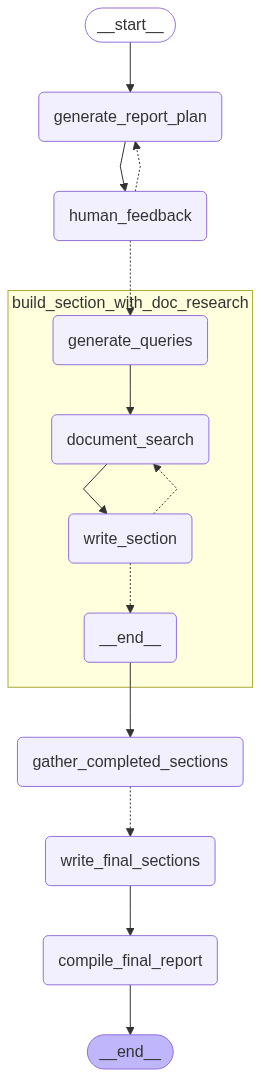

In [32]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display, Markdown

section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("document_search", document_search)
section_builder.add_node("write_section", write_section)

# Add edges
section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "document_search")
section_builder.add_edge("document_search", "write_section")


builder = StateGraph(ReportState, input=ReportStateInput, output=ReportStateOutput, config_schema=Configuration)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("human_feedback", human_feedback)
builder.add_node("build_section_with_doc_research", section_builder.compile())
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)

# Add edges
builder.add_edge(START, "generate_report_plan")
builder.add_edge("generate_report_plan", "human_feedback")
builder.add_edge("build_section_with_doc_research", "gather_completed_sections")
builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

# Test

In [33]:
import os
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'

In [34]:
import uuid 
from IPython.display import Markdown
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "max_search_depth": 1,
                           "report_structure": report_structure,}
                           }

topic = "당신은 조선소의 안전 관리자 입니다. 산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정을 해석할 때 고려하여야 할 사항에 대해 단계적으로 검토후 보고서를 작성해주세요."
async for event in graph.astream({"topic":topic,}, thread, stream_mode="updates", debug=True):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

[-1:checkpoint] State at the end of step -1:
{'completed_sections': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'topic': '당신은 조선소의 안전 관리자 입니다. 산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 '
          '형사처벌 규정을 해석할 때 고려하여야 할 사항에 대해 단계적으로 검토후 보고서를 작성해주세요.'}
[0:writes] Finished step 0 with writes to 1 channel:
- topic -> ('당신은 조선소의 안전 관리자 입니다. 산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정을 해석할 '
 '때 고려하여야 할 사항에 대해 단계적으로 검토후 보고서를 작성해주세요.')
[0:checkpoint] State at the end of step 0:
{'completed_sections': [],
 'topic': '당신은 조선소의 안전 관리자 입니다. 산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 '
          '형사처벌 규정을 해석할 때 고려하여야 할 사항에 대해 단계적으로 검토후 보고서를 작성해주세요.'}
[1:tasks] Starting 1 task for step 1:
- generate_report_plan -> {'completed_sections': [],
 'topic': '당신은 조선소의 안전 관리자 입니다. 산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 '
          '형사처벌 규정을 해석할 때 고려하여야 할 사항에 대해 단계적으로 검토후 보고서를 작성해주세요.'}
[1:writes] Finished step 1 with writes to 1 channel:
- sections -> [Section(name='서론', descripti

Please provide feedback on the following report plan. 
                        

Section: 서론
Description: 산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정의 개요
Research needed: No


Section: 도급인의 안전조치 및 보건조치
Description: 도급인의 안전조치 및 보건조치의무에 관한 규정
Research needed: Yes


Section: 도급 금지 작업 또는 고용노동부장관 승인대상 작업
Description: 도급 금지 작업 또는 고용노동부장관 승인대상 작업의 확인
Research needed: Yes


Section: 결론
Description: 산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정의 요약
Research needed: No


                        
Does the report plan meet your needs?
Pass 'true' to approve the report plan.
Or, provide feedback to regenerate the report plan:

In [35]:
cur_state = graph.get_state(thread)
cur_state.values
# report = final_state.values.get('final_report')
# Markdown(report)

{'topic': '당신은 조선소의 안전 관리자 입니다. 산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정을 해석할 때 고려하여야 할 사항에 대해 단계적으로 검토후 보고서를 작성해주세요.',
 'sections': [Section(name='서론', description='산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정의 개요', research=False, content='산업안전보건법은 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정을 정의합니다. 본 보고서는 이러한 규정의 해석과 적용에 관한 주요 사항을 다룹니다.'),
  Section(name='도급인의 안전조치 및 보건조치', description='도급인의 안전조치 및 보건조치의무에 관한 규정', research=True, content='도급인은 관계수급인 근로자의 산업재해 예방을 위하여 필요한 안전조치 및 보건조치의무를 지니고 있습니다. 이는 도급인의 사업장에서 일하는 근로자의 경우에도 적용됩니다.'),
  Section(name='도급 금지 작업 또는 고용노동부장관 승인대상 작업', description='도급 금지 작업 또는 고용노동부장관 승인대상 작업의 확인', research=True, content='도급 금지 작업 또는 고용노동부장관 승인대상 작업인지 확인하는 것은 산업안전보건법의 중요한 사항입니다. 본 섹션에서는 이러한 작업의 확인 방법에 관해 다룹니다.'),
  Section(name='결론', description='산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정의 요약', research=False, content='산업안전보건법은 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정을 정의합니다. 본 보고서는 이러한 규정의 해석과 적용에 관한 주요 사항을 요약합니다.')],
 'completed_sect

In [43]:
cur_state.next, cur_state.tasks

(('human_feedback',),
 (PregelTask(id='81d8a250-7b98-346d-a30f-e1ca6e35813c', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(Interrupt(value="Please provide feedback on the following report plan. \n                        \n\nSection: 서론\nDescription: 산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정의 개요\nResearch needed: No\n\n\nSection: 도급인의 안전조치 및 보건조치\nDescription: 도급인의 안전조치 및 보건조치의무에 관한 규정\nResearch needed: Yes\n\n\nSection: 도급 금지 작업 또는 고용노동부장관 승인대상 작업\nDescription: 도급 금지 작업 또는 고용노동부장관 승인대상 작업의 확인\nResearch needed: Yes\n\n\nSection: 결론\nDescription: 산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정의 요약\nResearch needed: No\n\n\n                        \nDoes the report plan meet your needs?\nPass 'true' to approve the report plan.\nOr, provide feedback to regenerate the report plan:", resumable=True, ns=['human_feedback:81d8a250-7b98-346d-a30f-e1ca6e35813c']),), state=None, result=None),))

In [45]:
graph.update_state(thread, {'topic':"state 업데이트 테스트 입니다."})

{'configurable': {'thread_id': '83109e1e-ac18-4b85-ad9d-2a733916b5cb',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03e421-a995-69af-8002-96efff8892c9'}}

In [46]:
cur_state = graph.get_state(thread)
cur_state.values

{'topic': 'state 업데이트 테스트 입니다.',
 'sections': [Section(name='서론', description='산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정의 개요', research=False, content='산업안전보건법은 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정을 정의합니다. 본 보고서는 이러한 규정의 해석과 적용에 관한 주요 사항을 다룹니다.'),
  Section(name='도급인의 안전조치 및 보건조치', description='도급인의 안전조치 및 보건조치의무에 관한 규정', research=True, content='도급인은 관계수급인 근로자의 산업재해 예방을 위하여 필요한 안전조치 및 보건조치의무를 지니고 있습니다. 이는 도급인의 사업장에서 일하는 근로자의 경우에도 적용됩니다.'),
  Section(name='도급 금지 작업 또는 고용노동부장관 승인대상 작업', description='도급 금지 작업 또는 고용노동부장관 승인대상 작업의 확인', research=True, content='도급 금지 작업 또는 고용노동부장관 승인대상 작업인지 확인하는 것은 산업안전보건법의 중요한 사항입니다. 본 섹션에서는 이러한 작업의 확인 방법에 관해 다룹니다.'),
  Section(name='결론', description='산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정의 요약', research=False, content='산업안전보건법은 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정을 정의합니다. 본 보고서는 이러한 규정의 해석과 적용에 관한 주요 사항을 요약합니다.')],
 'completed_sections': []}

In [40]:
for i in graph.get_state_history(thread):
    print(i)

StateSnapshot(values={'topic': '당신은 조선소의 안전 관리자 입니다. 산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정을 해석할 때 고려하여야 할 사항에 대해 단계적으로 검토후 보고서를 작성해주세요.', 'sections': [Section(name='서론', description='산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정의 개요', research=False, content='산업안전보건법은 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정을 정의합니다. 본 보고서는 이러한 규정의 해석과 적용에 관한 주요 사항을 다룹니다.'), Section(name='도급인의 안전조치 및 보건조치', description='도급인의 안전조치 및 보건조치의무에 관한 규정', research=True, content='도급인은 관계수급인 근로자의 산업재해 예방을 위하여 필요한 안전조치 및 보건조치의무를 지니고 있습니다. 이는 도급인의 사업장에서 일하는 근로자의 경우에도 적용됩니다.'), Section(name='도급 금지 작업 또는 고용노동부장관 승인대상 작업', description='도급 금지 작업 또는 고용노동부장관 승인대상 작업의 확인', research=True, content='도급 금지 작업 또는 고용노동부장관 승인대상 작업인지 확인하는 것은 산업안전보건법의 중요한 사항입니다. 본 섹션에서는 이러한 작업의 확인 방법에 관해 다룹니다.'), Section(name='결론', description='산업안전보건법상 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정의 요약', research=False, content='산업안전보건법은 건설공사 도급과 관련한 안전·보건조치의무 및 그 위반에 따른 형사처벌 규정을 정의합니다. 본 보고서는 이러한 규정의 해석과 적용에 관한 주요 사항을 요약합니다.')], 'c

In [41]:
feedback_msg = """
도급공사 안전사고에 관한 판례의 내용도 하나의 섹션으로 추가해주세요.
"""
res = Command(resume=feedback_msg)
res

Command(resume='\n도급공사 안전사고에 관한 판례의 내용도 하나의 섹션으로 추가해주세요.\n')

In [42]:
feedback_msg = True
res = Command(resume=feedback_msg)
res

Command(resume=True)

In [ ]:
feedback_msg = """
도급공사 안전사고에 관한 판례의 내용도 하나의 섹션으로 추가해주세요.
"""

async for event in graph.astream(Command(resume=feedback_msg), thread, stream_mode="updates"):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

In [ ]:
feedback_msg = True

async for event in graph.astream(Command(resume=True), thread, stream_mode="updates"):
    print(event)
    print("\n")

In [ ]:
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)